In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt

*Last Monday I said Naive Bayes is the first data analysis method we have that is good for what type of data? Quantitative or Qualitative?*

# Naive Bayes for Text

Text data, *without preprocessing*, is qualitative data. Let's use Naive Bayes to classify some text data! 

I'm going to be using the SMS dataset from [here](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).

## I. Load and Look at our data

Let's load and __look at our data__. Is our independent variable at the *start* or the *end*?

In [2]:
data = np.array(np.genfromtxt('data/SMSSpamCollection', delimiter='\t', encoding='utf-8', dtype=str))  
print(data.shape)

(5574, 2)


How many labels do we have?

In [3]:
print(np.unique(data[:, 0], return_counts=True))

(array(['ham', 'spam'], dtype='<U910'), array([4827,  747], dtype=int64))


## II. Split the data

Let's split it into train, dev, test and make sure we have some of each label in each subset

In [4]:
train, dev, test = np.split(data, [int(.8 * len(data)), int(.9 * len(data))])
print(train.shape, dev.shape, test.shape)
print(np.unique(train[:, 0], return_counts=True))
print(np.unique(dev[:, 0], return_counts=True))
print(np.unique(test[:, 0], return_counts=True))

(4459, 2) (557, 2) (558, 2)
(array(['ham', 'spam'], dtype='<U910'), array([3857,  602], dtype=int64))
(array(['ham', 'spam'], dtype='<U910'), array([484,  73], dtype=int64))
(array(['ham', 'spam'], dtype='<U910'), array([486,  72], dtype=int64))


So far, so good!

## III. Preprocess the data

*But*, how do I deal with the SMS texts themselves? Well, a SMS is composed of word-type things (let's call them "tokens") and if I *completely ignore* the sequence information then I could say each SMS is composed of a bag of tokens. 

NOTE that to do this hurts me as a computational linguist. Of *course* word order matters! In particular, in this context it means that the token occurrences are not *independent* of each other. But we are going to pretend they are, thus lacerating the sensibilities of both linguists and statisticians in search of a computationally efficient approximation.

__Our independent variables will be what, now?__

### Let's define a function to get the bag of tokens from the text of a SMS

In [5]:
# We will split the text on any character(s) that are not letters or numbers,
# and then keep anything that is not whitespace
def tokenize(text):
    return [token.strip() for token in re.split(r'([^A-Za-z0-9]+)', text) if not re.match(r'^\s*$', token)]

In [6]:
# Try it on one SMS
tokenize(train[0][1])

['Go',
 'until',
 'jurong',
 'point',
 ',',
 'crazy',
 '..',
 'Available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 '...',
 'Cine',
 'there',
 'got',
 'amore',
 'wat',
 '...']

### Let's get the unique tokens

In [7]:
tokens = set()
for i in range(len(train)):
    tokens = tokens.union(tokenize(train[i][1]))
print(len(tokens))

9801


That's entirely too many tokens! Let's keep just from the $a$ to the $b$ most frequent ones.

In [8]:
a = 500
b = 4000
tokens = []
for i in range(len(train)):
    tokens.extend(tokenize(train[i][1]))
uniqueTokens, tokenCounts = np.unique(tokens, return_counts=True)
topUniqueTokens = uniqueTokens[np.argsort(tokenCounts)[::-1]][a:b]
print(len(topUniqueTokens))

3500


### Let's collect token counts across all the 'ham' SMSs, and separately across all the 'spam' SMSs

In [9]:
def preprocessCategory(subsetOfData, tokenVocab):
    tokens = []
    res = dict.fromkeys(tokenVocab, 0)
    for i in range(len(subsetOfData)):
        tokens.extend(tokenize(subsetOfData[i][1]))
    uniqueTokens, tokenCounts = np.unique(tokens, return_counts=True)
    for token, count in zip(uniqueTokens, tokenCounts):
        if token in res:
            res[token] += count
    return res

tokenCounts = {}
tokenCounts['ham'] = preprocessCategory(train[np.where(train[:, 0] == 'ham')], topUniqueTokens)
tokenCounts['spam'] = preprocessCategory(train[np.where(train[:, 0] == 'spam')], topUniqueTokens)
# We keep this around for indexing into the likelihoods
sortedTokens = sorted(topUniqueTokens)
print(len(sortedTokens))

3500


Pay attention to the sleight of hand here:
* Our labels are 'ham' and 'spam'.
* Our features are individual token frequencies calculated across all of 'ham' and all of 'spam'. We *assume independence in the features*. That's the naive in Naive Bayes.

## Fit

So now let's fit a Naive Bayes model for spam detection

To fit, we need to calculate:
* priors - $P(ham)$ and $P(spam)$
* likelihoods - for any token $x$, $P(x|ham)$ and $P(x|spam)$

### Priors

Calculating priors will be easy. 

In [10]:
priors = {'ham': len(train[np.where(train[:, 0] == 'ham')]) / len(train), 'spam': len(train[np.where(train[:, 0] == 'spam')]) / len(train)}
print(priors)

{'ham': 0.8649921507064364, 'spam': 0.13500784929356358}


### Likelihoods

Calculating likelihoods will be tricky, because:.
* Sometimes the likelihoods will be 0, as a token will occur *no* times in one of 'ham' or 'spam'.
* A lot of the likelihoods will be veerrrry small, as most of the tokens occur only once.

To deal with these, we:
* 0s - use *Laplace smoothing*, as we discussed last session.
* veerrrry small - move from regular count space to log space (see plot).
  * in 'regular count space' $P(I, like, candy) | ham) = P(I|ham)*P(like|ham)*P(candy|ham)$.
  * in 'log space' $P(I, like, candy) | ham) = log(P(I|ham)) + log(P(like|ham)) + log(P(candy|ham))$, because the logarithm of a product is the sum of the logarithms.


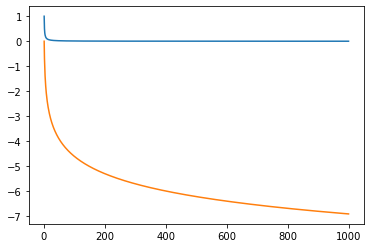

In [11]:
res = np.array([[i, 1/i, np.log(1/i)] for i in range(1, 1000)])
plt.plot(res[:, 0], res[:, 1])
plt.plot(res[:, 0], res[:, 2])
plt.show()

In [12]:
def calculateLikelihoods(data):
    likelihoods = {}
    cats = np.unique(train[:, 0])
    for cat in cats:
        likelihoods[cat] = {}
        for token in sortedTokens:
            likelihoods[cat][token] = np.log((tokenCounts[cat][token] + 1) / 
                                             (len(np.where([data[:, 0] == cat])) + len(sortedTokens)))
    return likelihoods

In [13]:
likelihoods = calculateLikelihoods(train)
print(len(likelihoods))
print(len(likelihoods['ham']))
print(len(likelihoods['spam']))

2
3500
3500


## Predict

Let's use the Naive Bayes model we fit to predict the class for each item in our test data.

We will have to tokenize each SMS, of course.

In [21]:
def pTextGivenCategory(text, cat):
    tokens = tokenize(text)
    sum = 0
    for token in tokens:
        # if the token is not in our vocab from train, it just gets dropped
        try:
            likelihood = likelihoods[cat][token]
        except:
            likelihood = 0
        # we add instead of multiply, because we are in log space
        sum += likelihood
    return sum
        
def predict(data):
    labels = []
    cats = np.unique(data[:, 0])
    for i in range(len(data)):    
        res = []
        for cat in cats:
            res.append(np.log(priors[cat]) + pTextGivenCategory(dev[i][1], cat))
        labels.append((cats[np.argmax(res)], np.exp(res[np.argmax(res)])))
    return labels

In [22]:
labels = predict(dev)
print(labels)

[('ham', 1.316777567981378e-17), ('spam', 3.0938188257431347e-25), ('ham', 1.850055691611035e-22), ('ham', 1.5889836193386443e-25), ('ham', 9.868697143833262e-09), ('ham', 8.237377811981178e-13), ('ham', 3.3231327116989584e-09), ('spam', 1.2064066449156388e-12), ('ham', 0.0024699947193216336), ('ham', 6.437829730903495e-36), ('ham', 9.788136350822405e-09), ('ham', 1.2605050223411542e-16), ('ham', 4.894068175411211e-09), ('ham', 5.9951328138874634e-06), ('ham', 1.047290309141491e-09), ('ham', 0.004692989966711106), ('ham', 1.268832489921423e-09), ('ham', 0.0009879978877286534), ('ham', 0.0007409984157964901), ('ham', 1.885122556454685e-08), ('ham', 0.8649921507064364), ('ham', 0.8649921507064364), ('ham', 5.6424779424823256e-06), ('ham', 1.9043363055877856e-06), ('ham', 3.808672611175565e-06), ('ham', 1.5144417137351317e-18), ('ham', 5.238061841398706e-11), ('ham', 1.057964614215435e-06), ('ham', 0.8649921507064364), ('ham', 2.4978173149966868e-14), ('ham', 0.0039519915509146145), ('ham

## Score

Let's get accuracy and the confusion matrix.

In [23]:
# These come directly from day 24

def accuracy(y, yhat):
    assert len(y) == len(yhat)
    diffs = y == yhat
    vals, counts = np.unique(diffs, return_counts=True)
    return counts[np.where(vals == True)] / (np.sum(counts))
    
def confusionMatrix(y, yhat):
    "Thanks to https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python"
    allLabels = sorted(list(np.union1d(y, yhat)))
    print(allLabels)
    assert len(y) == len(yhat)
    result = np.zeros((len(allLabels), len(allLabels)))
    for i in range(len(y)):
        result[allLabels.index(y[i])][allLabels.index(yhat[i])] += 1
    return result

In [24]:
accuracy([x[0] for x in labels], dev[:, 0])

array([0.96768402])

In [25]:
confusionMatrix([x[0] for x in labels], dev[:, 0])

['ham', 'spam']


array([[483.,  17.],
       [  1.,  56.]])

Note that accuracy isn't super helpful here, since there are so many 'ham' emails. 

Question: *What would the accuracy be if the model just labeled __everything__ as 'ham'?*

## TPR, FPR, Precision, Recall, F, ROC, AUC

Let's make a different version of the confusion matrix focusing on just the 'spam' class, which is the class we really want to do well on:

| | Predict not in 'spam' | Predict in 'spam' | Rates |
| -- | --- | --- | -- |
| Actual not in 'spam' | TN | FP | FPR = FP/(FP+TN) |
| Actual in 'spam' | FN | TP | TPR = TP/(TP+FN) |

With a table like this, we can also calculate:
* Precision (how many of those we guessed were 'spam' were actually 'spam'?): TP / (TP + FP)
* Recall (how many actual 'spam' did we guess were 'spam'?): TP / (TP + FN)

Then, to get an assessment of recall and precision together, we can calculate F1: (2\*Precision\*Recall)/(Precision+Recall)

We can also plot the ROC curve and calculate AUC.
* ROC - receiver operating characteristic curve, constructed by plotting the TPR against the FPR
* AUC - area under the ROC curve

Here is a good introduction to these: https://www.displayr.com/what-is-a-roc-curve-how-to-interpret-it/

We will plot the ROC curve using sklearn.

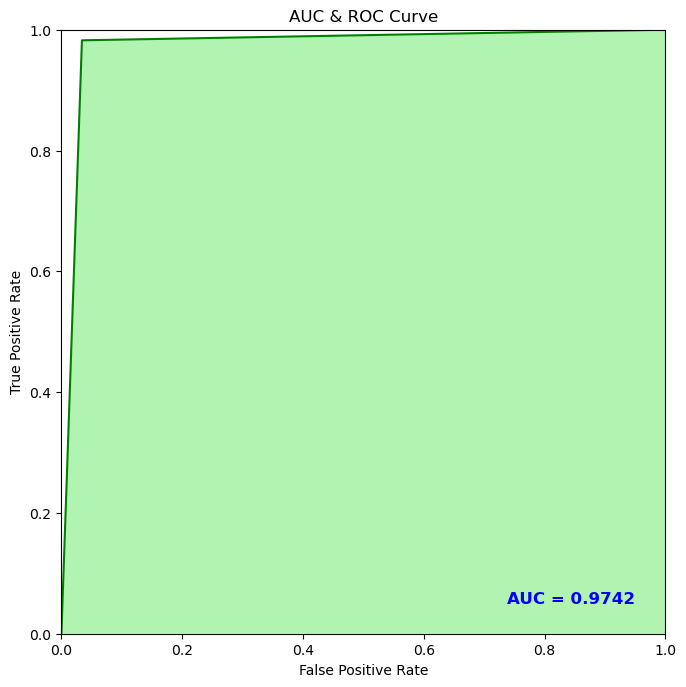

In [28]:
from sklearn import metrics

# This code comes from https://thecleverprogrammer.com/2021/04/07/auc-and-roc-curve-using-python/

# Have to convert the labels to ints for the sklearn implementation
labelmap = ['ham', 'spam']
auc = metrics.roc_auc_score([labelmap.index(x[0]) for x in labels], [labelmap.index(x) for x in dev[:, 0]])

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve([labelmap.index(x[0]) for x in labels], [labelmap.index(x) for x in dev[:, 0]])

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Are we happy?

We could potentially do better:
* We could add information from *outside the text*. Modern spam filters use features like whether the sender's email address is the same as the reply-to email address, whether the IP address the email comes from matches that of the domain of the sender's email address, whether this same email is being sent to a lot of people at the same time, whether this sender has ever emailed this recipient before (and how often), and all kinds of behavioral features.
* We have a *class imbalance*: there are a lot more 'ham' emails than there are 'spam' emails. We can deal with this by *changing the decision threshold*, *downsampling* the 'ham' emails, *upsampling* (repeating) the 'spam' emails, or [other techniques](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/?msclkid=33d6b961b9df11ec98e519046a973ddf).

Resources:
* https://towardsdatascience.com/roc-curve-and-auc-from-scratch-in-numpy-visualized-2612bb9459ab
* https://towardsdatascience.com/roc-and-auc-how-to-evaluate-machine-learning-models-in-no-time-fb2304c83a7f